# Exploring Lending Club Data

### Summary
**Big Picture Summary:** The purpose of this notebook is to explore certain aspects of the Lending Club Data that was cleaned in the notebook [Data_Wrangling.ipynb](https://github.com/paulb17/Springboard/blob/master/Capstone%20Project%201/Data_Wrangling%20.ipynb). Once the data is explored, it will be used to create a loan classification model for conservative investors in the notebook [Data_Modeling.ipynb](). 

**Explored questions:** As conservative investors are the audience for this project, the questions investigated are in relation to them. These question include:
1. Where in the risk spectrum to Lending Club Borrowers fall?
    * We analyze this using FICO scores
2. Manual Investing -  we take a look at the risks associated with investing using the following metrics:
    * Credit histories
    * Employment histories
    * Annual income
    * Loan amount requested
3. Will categorizing the employer title column provide useful insights to investors?
4. Do sub-grades make a difference in the risk of default?

## Importing the data

In [1]:
# importing relevant packages
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

# creating plots using seaborn setting 
sns.set()

# using jupyter magic to display plots in line
%matplotlib inline

# importing the dataset
loan_data = pd.read_csv('Wrangled_Loan_data.csv', low_memory=False)

A quick view of the data is shown below to ensure it was imported correctly

In [2]:
# viewing the size of the dataset
print('The size of the dataset: ' + str(loan_data.shape))

# viewing the first few columns of the dataset
loan_data.head()

The size of the dataset: (39736, 79)


,loan_amnt,int_rate,installment,grade,sub_grade,emp_length,annual_inc,loan_status,dti,delinq_2yrs,...,OH,OR,PA,SC,South,TX,VA,WA,WI,West
0,5000.0,10.65,162.87,2.0,7.0,10.0,24000.0,1,27.65,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2500.0,15.27,59.83,3.0,14.0,0.0,30000.0,0,1.00,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2400.0,15.96,84.33,3.0,15.0,10.0,12252.0,1,8.72,0.0,...,0,0,0,0,0,0,0,0,0,0
3,10000.0,13.49,339.31,3.0,11.0,10.0,49200.0,1,20.00,0.0,...,0,0,0,0,0,0,0,0,0,0
4,3000.0,12.69,67.79,2.0,10.0,1.0,80000.0,1,17.94,0.0,...,0,1,0,0,0,0,0,0,0,0


Next, to get a better understanding of the data that will be used a quick look through the column names and the data types of each column is shown below:

In [3]:
# displaying column names
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39736 entries, 0 to 39735
Data columns (total 79 columns):
loan_amnt                                 39736 non-null float64
int_rate                                  39736 non-null float64
installment                               39736 non-null float64
grade                                     39736 non-null float64
sub_grade                                 39736 non-null float64
emp_length                                39736 non-null float64
annual_inc                                39736 non-null float64
loan_status                               39736 non-null int64
dti                                       39736 non-null float64
delinq_2yrs                               39736 non-null float64
inq_last_6mths                            39736 non-null float64
mths_since_last_delinq                    39736 non-null int64
mths_since_last_record                    39736 non-null int64
open_acc                                  39736 non-

## Data Story

### Where in the risk spectrum do Lending Club borrowers fall?

Prior to investing in Lending Club, it is important for an investor to understand where in the risk spectrum borrowers fall. To evaluate this, we shall take a look at the borrowers FICO scores. 

FICO scores are used by many lenders to determine how risky a borrower is. For this reason, it is expected that borrowers that defaulted on their loans will have lower average FICO scores than borrowers that fully paid their loans. Let's see whether this expectation holds.

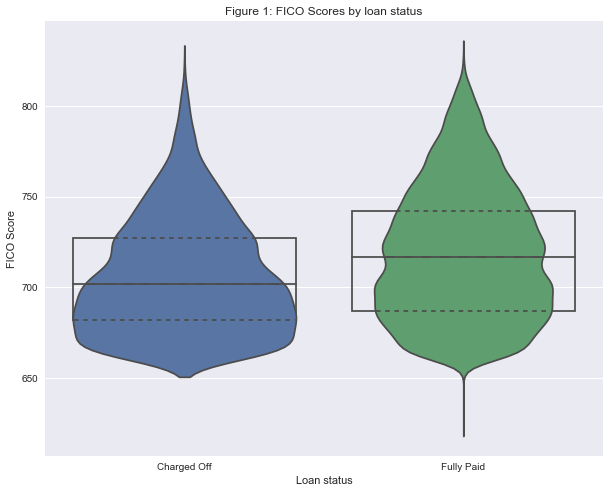

In [4]:
# filtering fully paid borrowers and charged off borrowers
fully_paid = loan_data[loan_data['loan_status'] == 1]
charged_off = loan_data[loan_data['loan_status'] == 0]


# creating box-plot and violin plot
plt.figure(figsize = (10,8))
sns.violinplot(x="loan_status", y='fico_average', data = loan_data, inner = 'quartile')
sns.boxplot(x="loan_status", y='fico_average', data = loan_data,
        showcaps=False, boxprops={'facecolor':'None'},
        showfliers=False,whiskerprops={'linewidth':0})

plt.title('Figure 1: FICO Scores by loan status')
plt.ylabel("FICO Score")
plt.xlabel('Loan status')
plt.xticks([0, 1], ['Charged Off', "Fully Paid"])
plt.rcParams.update({'font.size': 40})

We see in Figure 1 that our expectations appear to hold: the average FICO score of borrowers that defaulted on their loans is lower than that of borrowers that fully paid their loans. To check whether the difference in average FICO scores is significant, a hypothesis test is used.  

#### Hypothesis test 1

The null and alternative hypothesis are stated below:
* H<sub>0</sub>: $\mu$<sub>C</sub> = $\mu$<sub>F</sub>
* H<sub>1</sub>: $\mu$<sub>C</sub> $\neq$ $\mu$<sub>F</sub>

In words, 
* The null hypothesis states that there is not a significant difference in the average FICO scores between borrowers that were charged off (C) and borrowers that fully paid thier loans (F). 
* The alternative hypothesis states there is a significant difference in the average FICO scores between borrowers that were charged off and borrowers that fully paid thier loans. 


A two-tailed t-test is used. The test is carried out at the 5% significance level.

In [5]:
# calculating the test statistic and p-value
st.ttest_ind(fully_paid.age_cr_line, charged_off.age_cr_line)

Ttest_indResult(statistic=3.6425237227663625, pvalue=0.00027032129808026914)

The p-value 0.00027 is less than 5%, consequently we reject the null hypothesis. The results suggests that there is a significant difference in the average FICO scores of charged off borrowers relative to borrowers that fully paid their loans. 

Based on this result, we can expect that as FICO scores increase the proportion of charged off borrowers will decrease on average. Below, we show the proportion of borrowers that defaulted in various FICO score ranges and the distribution of FICO scores.

(680, 845)

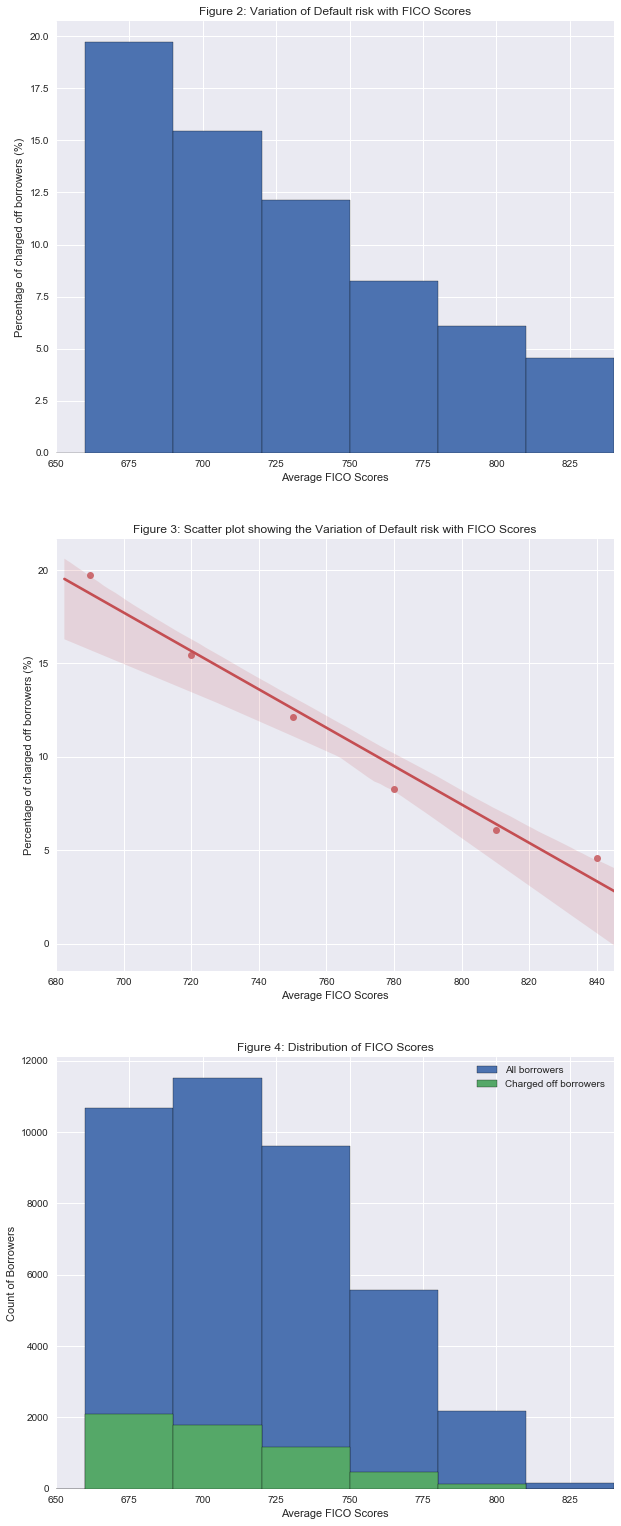

In [6]:
# creating empty list for bins and specifying bin widths 
bin_edges = list()
bin_width = 30

# assigning the range of FICO scores to be displayed 
max_el = 840
min_el = 650

# filling in list of bin widths
for num in range(int(round((max_el/bin_width)+1))):
    bin_edges.append((num)*bin_width)


# making plots
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (10,27))

# plotting distribution of FICO scores
ax3.set_title("Figure 4: Distribution of FICO Scores")
ax3.set_xlabel("Average FICO Scores")
ax3.set_ylabel('Count of Borrowers')
ax3.set_xlim([min_el,max_el])

# counting the number of borrowers in each FICO score category 
counts_tot, bins_tot, bars_tot= ax3.hist(loan_data.fico_average, bins = bin_edges, 
                                         label = 'All borrowers', edgecolor = 'k')

# count of the number of borrowers in each FICO score category that were charged off
counts, bins, bars = ax3.hist(charged_off['fico_average'], bins = bin_edges, 
                              label = "Charged off borrowers", edgecolor = 'k')

# adding a legend to the plot
plt.legend()

# Make a bar chart showing the proportions of FICO scores
ax1.set_title("Figure 2: Variation of Default risk with FICO Scores")

# ignoring divisions by 0
with np.errstate(divide='ignore', invalid='ignore'):
     
    proportions = 100*counts/counts_tot
    ax1.bar(np.arange(0, max_el, bin_width), height = proportions, width = bin_width, align = 'edge',
            edgecolor = 'black')
    ax1.set_xlim([min_el,max_el])
    ax1.set_xlabel("Average FICO Scores")
    ax1.set_ylabel("Percentage of charged off borrowers (%)")
    ax1.plot(x = bin_edges[-6:], y= proportions[-6:])


# creating data frame for seaborn plot
FICO_df = pd.DataFrame({'bin_edges' :bin_edges[-6:], 'proportions' :proportions[-6:]})
sns.regplot('bin_edges', 'proportions', data = FICO_df, ax=ax2)

ax2.set_title("Figure 3: Scatter plot showing the Variation of Default risk with FICO Scores")
ax2.set_xlabel("Average FICO Scores")
ax2.set_ylabel("Percentage of charged off borrowers (%)")
ax2.set_xlim([680, 845])

As expected, there is a clear trend in Figure 2 showing that the risk of a borrower defaulting decreases as FICO scores increase on average. We see that the lowest FICO score range (660-690) has a default rate of about 20% while highest FICO score range (810-830) has a default rate of about 5%. 

Figure 3, above better illustrates this trend. To verify that there is a relationship between the proportion of charged off borrowers and FICO scores, we shall carry out a hypothesis test using spearman's rank order correlation coefficient. 

#### Hypothesis test 2

The null and alternative hypothesis are stated below:
* H<sub>0</sub>: $\rho$ = 0 
* H<sub>1</sub>: $\rho$ $\neq$ 0

In words, 
* The null hypothesis states that there is no significant relationship between the proportion of charged off borrowers and FICO Scores. 
* The alternative hypothesis states that there is a significant relationsip between the proportion of charged off borrowers and FICO Scores.

The hypothesis is carried out at the 5% significant level. 

In [7]:
# calculating the correlation coeeficient and p-value
corr_coeff, p_val = st.spearmanr(bin_edges[-6:], proportions[-6:])

print('Spearman\'s Correlation Coefficient: ' + str(corr_coeff))
print('p-value: ' + str(p_val))

Spearman's Correlation Coefficient: -1.0
p-value: 0.0


Given the p-value of 0 is less than 5%, we reject the null hypothesis. The results suggest that there is a significant relationship between the proportion charged off borrowers and FICO scores at the 5% significant level. Based on this result we can conclude that borrowers with higher FICO scores are less likely to default. 

The FICO score distribution is shown in Figure 4. A quick review of it reveals that Lending Club borowers tend to have FICO scores ranging from 660 to 830.

![title](https://github.com/paulb17/Springboard/blob/master/Capstone%20Project%201/FICO%20Score%20ranges.pdf)

The above table obtained from the [FICO website](https://www.myfico.com/Downloads/Files/myFICO_UYFS_Booklet.pdf), contains descriptions of FICO scores based on categorized ranges. From the table, we can tell that Lending Club borrowers generally have FICO scores that are categorized as good, very good and exceptional. This is a clear indicator that Lending Club attempts to offer investors less risky borrowers. 

Within the selected borrowers available on Lending Club, the FICO score distribution (Figure 3) is rightly skewed. This suggests that most of the borrowers available in the Lending Club market place are in the good FICO score category: a category that consists of borrowers with credit risks less than or approximately equivalent to that of the average U.S. consumer. 

### Manual Investing in Lending Club
Given that we know where in the credit risk spectrum Lending Club borrowers fall, we now look into how investors can further minimize risks. Investors in the Lending Club market place have the option to select the borrowers they invest in. With so many borrowers and metrics available it is often difficult to decide what features are most likely to minimize the risk of default. Below, we investigate some common metrics investors may want to use when deciding between one borrower or another. 

#### Credit histories
Credit history is an important component used in the evaluation of a borrowers' credit risk. The FICO score models use a borrower's credit history (age of oldest account, age of newest account and average age of all accounts) in determining credit risk; in fact, borrowers typically require at least 3 years of credit history to be in the exceptional FICO score category.  

To investigate how credit history should impact the decisions of Lending Club investors, we start by plotting a graph showing the average FICO scores of borrowers grouped by age of oldest credit accounts. 

(660, 760)

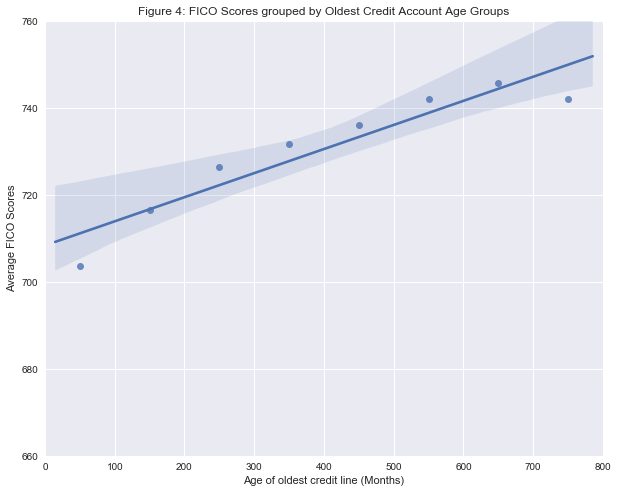

In [8]:
# creating empty list for bins and specifying bin widths
bin_edges = list()
bin_width = 100

# filling in list of bin widths
for num in range(int(round((800/bin_width)+1))):
    bin_edges.append((num)*bin_width)

# creating a counter for the number of age groups
age_group_counter = 0

# creating a place holder for credit age groups (CAG)
CAG_charged_off = pd.DataFrame()
CAG_fully_paid = pd.DataFrame()
CAG_all_borrowers = pd.DataFrame()

# creating a for loop to group borrowers by age group
for index, age in enumerate(bin_edges):   
    
    # checking if all age groups are created
    if age_group_counter == len(bin_edges) - 1:
        break
    
    # creating credit age groups 
    else:
        age_group = loan_data[(loan_data['age_cr_line'] >= bin_edges[index]) &
                              (loan_data['age_cr_line'] < bin_edges[index+1])]
        age_group_counter +=1
        column_name = str(bin_edges[index]) + "-" + str(bin_edges[index+1])
        
        # credit age group for charged_off borrowers
        CAG_all_borrowers[column_name] = age_group.mean()
        
        # credit age group for charged_off borrowers
        CAG_charged_off[column_name] = age_group[age_group.loan_status == 0].mean()

        # credit age group for fully paid borrowers
        CAG_fully_paid[column_name] = age_group[age_group.loan_status == 1].mean()
        
# calculating proportion of charged of borrowers with public record benakruptcies
prop_C = CAG_charged_off.loc['fico_average']
prop_fully_paid = CAG_fully_paid.loc['fico_average']
prop_all = CAG_all_borrowers.loc['fico_average']

# Making histogram
fig, ax1 = plt.subplots(figsize = (10,8))

sns.regplot(x = np.arange(50, 850, bin_width), y = prop_all)


plt.title('Figure 4: FICO Scores grouped by Oldest Credit Account Age Groups')
plt.xlim([0,800])
plt.xlabel("Age of oldest credit line (Months)")
plt.ylabel("Average FICO Scores")
plt.ylim([660,760])



It should be noted that in Figure 4, the minimum reading on the y-axis is 660. We also see in the figure that as the age of oldest credit account increases, the average FICO score increases. We investigate whether there is a significant relationship between FICO scores and the Age of oldest credit account using a hypothesis test.

**Hypothesis test 3**

The null and alternative hypothesis are stated below:
* H<sub>0</sub>: $\rho$ = 0 
* H<sub>1</sub>: $\rho$ $\neq$ 0

In words, 
* The null hypothesis states that there is no significant relationship between the age of oldest credit account and FICO Scores. 
* The alternative hypothesis states that there is a significant relationsip between the age of oldest credit account  and FICO Scores.

The hypothesis is carried out at the 5% significant level. 

In [9]:
# calculating the correlation coeeficient and p-value
x = np.arange(50, 850, bin_width)
corr_coeff, p_val = st.spearmanr(x, prop_all)

print('Spearman\'s Correlation Coefficient: ' + str(corr_coeff))
print('p-value: ' + str(p_val))

Spearman's Correlation Coefficient: 0.928571428571
p-value: 0.0008629681829


Given the p-value of 0.00086 is less than 5%, we reject the null hypothesis. The results suggest that there is a significant relationship between the age of oldest credit account and FICO scores at the 5% significant level. Based on this result, we can conclude that borrowers with greater age of oldest credit accounts tend to have higher FICO scores.

Hypothesis test 2 verified that borrowers in higher FICO score categories tend to have a lower proportion of defaulters. Based on the association between FICO scores and age of oldest credit account, we should expect the proportion of borrowers that default decreases as the age of oldest credit account increases. Below we plot graphs to visualize whether this relationship holds.

Text(0,0.5,'Percentage of charged off borrowers (%)')

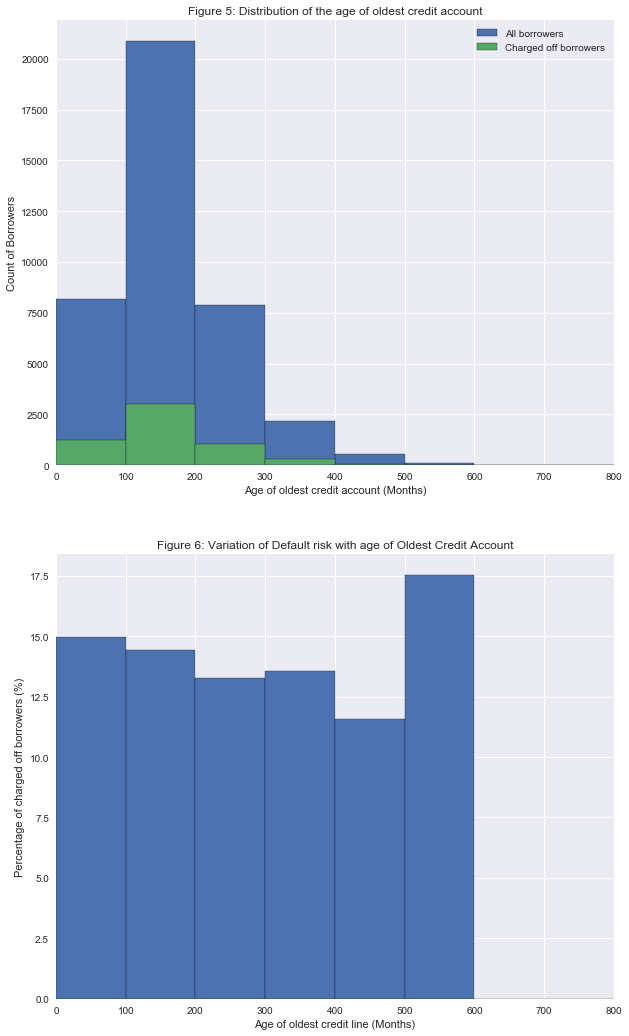

In [10]:
# creating empty list for bins and specifying bin widths
bin_edges = list()
bin_width = 100

# filling in list of bin widths
for num in range(int(round((800/bin_width)+1))):
    bin_edges.append((num)*bin_width)

# creating the figure
plt.figure(figsize = (10,18))

# plotting the distribution of ages of oldest credit account
plt.subplot(2,1,1)
plt.title('Figure 5: Distribution of the age of oldest credit account')
plt.xlabel("Age of oldest credit account (Months)")
plt.ylabel('Count of Borrowers')
plt.xlim([0,800])

# counting the number of borrowers in each age of account group 
counts_tot, bins_tot, bars_tot= plt.hist(loan_data.age_cr_line, bins = bin_edges, 
                                         label = 'All borrowers', edgecolor = 'k')

# count of the number of borrowers in each age of account group that were charged off
counts, bins, bars = plt.hist(charged_off['age_cr_line'], bins = bin_edges, 
                              label = "Charged off borrowers", edgecolor = 'k')

# adding a legend to the plot
plt.legend()

# calculating the proportions 
proportions = 100*counts/counts_tot

# Making a chart showing the proportions 
plt.subplot(2, 1, 2)
plt.bar(np.arange(0, 800, bin_width), height = proportions, width = bin_width, align = 'edge',
        edgecolor = 'black')
plt.title('Figure 6: Variation of Default risk with age of Oldest Credit Account')
plt.xlim([0,800])
plt.xlabel("Age of oldest credit line (Months)")
plt.ylabel("Percentage of charged off borrowers (%)")

Prior to looking at the plot showing the variation of default risk with age of oldest credit account, it is important to note a few things about the distribution of the age of borrowers' oldest credit accounts. This is shown in Figure 5. We can see in the figure that most borrowers offered to investors in the Lending Club market place have an oldest credit account aged between 100 to 200 months. More importantly, we note that the total number of borrowers in the last few age of oldest credit account groups are relatively small when compared to other age groups. The table below displays the oldest credit account age groups with the fewest borrowers.

|   Oldest age of Credit Account (Months)| Count of people in category   | Count of people charged off     |
|----------------------------------------|-------------------------------|---------------------------------|
|  500 - 600                             |               97              |             17                  |
|  600 - 700                             |                 4             |             0                   |
|  700 - 800                             |                 2             |             0                   |

In Figure 6, we note that for the first 500 months, the percentage of defaulters *generally* decreases as the age of oldest credit account increases. For borrowers whose oldest credit accounts are aged between 500-600 months, there is a significant increase in the percentage of defaulters. This unexpected deviation from the trend is an indicator that age of oldest credit account on its own may not be sufficient to determine a borrowers credit risk. It also explains why the credit history component of the FICO score model accounts for only 15% of a borrowers credit score: other factors which measure how well credit accounts have been managed over time account for the other 85%.

Below we plot the average FICO score of fully paid and charged off borrowers in each age group to visualize whether the FICO score model accounts for the unexpected deviation. 

Text(0,0.5,'Average FICO Score Differences (Fully Paid - Charged off)')

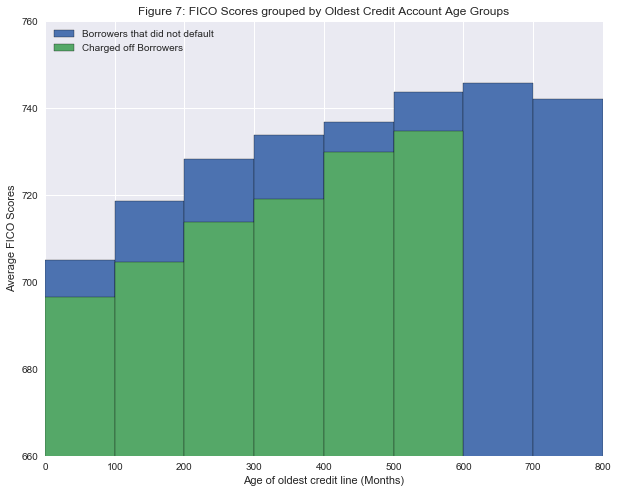

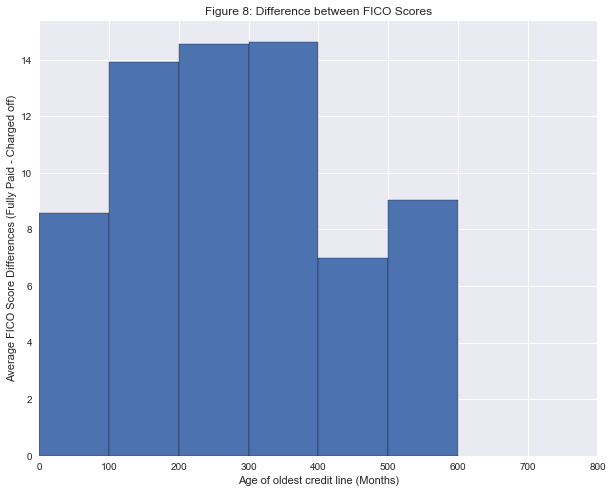

In [11]:
# Making histogram in Figure 7
fig, ax1 = plt.subplots(figsize = (10,8))

plt.bar(np.arange(0, 800, bin_width), height = prop_fully_paid,  width = bin_width, align = 'edge', 
        edgecolor = 'black', label = 'Borrowers that did not default')
plt.bar(np.arange(0, 800, bin_width), height = prop_C,  width = bin_width, align = 'edge', 
        edgecolor = 'black', label = 'Charged off Borrowers')


plt.legend()

plt.title('Figure 7: FICO Scores grouped by Oldest Credit Account Age Groups')
plt.xlim([0,800])
plt.xlabel("Age of oldest credit line (Months)")
plt.ylabel("Average FICO Scores")
plt.ylim([660,760])

# Making histogram in figure 8
fig2, ax2 = plt.subplots(figsize = (10,8))

plt.bar(np.arange(0, 800, bin_width), height = prop_fully_paid-prop_C,  width = bin_width, align = 'edge', 
        edgecolor = 'black')

plt.title('Figure 8: Difference between FICO Scores')
plt.xlim([0,800])
plt.xlabel("Age of oldest credit line (Months)")
plt.ylabel("Average FICO Score Differences (Fully Paid - Charged off)")


It should be noted that in Figure 7 the y-axis starts from a FICO score of 660. Based on the figure, average FICO scores appear to increase as the age of oldest credit accounts increase. This occurs for both borrowers that are charged off and borrowers that fully paid their loans. We also note that borrowers that are charged off tend to have lower FICO scores relative to borrowers that fully paid their loans. This agrees with our findings in hypothesis tests 1 and 2. 

However, we see from Figure 8 that the unexpected deviation shown in Figure 6 is not explained by the average FICO score differences between fully paid and charged off borrowers; if it were explained by FICO score differences, we would expect to see a decreasing trend for the 0-500 age of oldest credit account category and a spike in the 500-600 age of oldest credit account category. 

A more thorough evaluation of what is causing the deviation observed in Figure 6 can be achieved by reviewing borrowers' reasons for taking the loan. Let's do this below.

In [12]:
# creating a list of purposes for borrowing 
purposes = list()

for column_name in loan_data.columns.tolist():
    if 'purpose' in column_name:
        purposes.append(column_name)
        
# displaying columns that contribute to default in 500-600 months category
Contributions = CAG_charged_off.loc[purposes, :]*proportions
Contributions.iloc[:,:-2][(Contributions['500-600']!=0)]

,0-100,100-200,200-300,300-400,400-500,500-600
purpose_credit_card,1.270307,1.351934,1.586093,1.207617,1.627486,1.030928
purpose_debt_consolidation,6.534750,7.296611,7.029565,6.595448,5.063291,6.185567
purpose_home_improvement,0.598510,0.910878,0.837457,1.532745,1.084991,4.123711
purpose_other,2.149750,1.567669,1.154676,1.532745,0.904159,1.030928
purpose_small_business,1.258092,1.208112,1.103921,1.254064,1.446655,2.061856
purpose_vacation,0.109930,0.148617,0.114199,0.139340,0.000000,1.030928


The table above shows the percentage of borrowers in each age group that were charged off, categorized by their reasons for taking the loan. 

A visual inspection of the table reveals that the major cause of the increase in default risk of borrowers with oldest credit accounts aged between 500-600 months arises from the people who borrow money for home improvement: the 4.1% contribution for the 500-600 months age of oldest account category is much higher than the 0.5% -1.5% contributions we see from other age of oldest credit account categories. We also note that some less significant contributors to the increase in default riks in the 500-600 age of credit accounts category are borrowers requesting money for vacations and small businessis. 

It is worth understanding why borrowers who are trying to improve their homes play such a significant role in the defatult risk for oldest credit accounts aged between 500-600 months. To this end, we plot a graph showing the proportion of borrowers that loaned money for home improvement. 

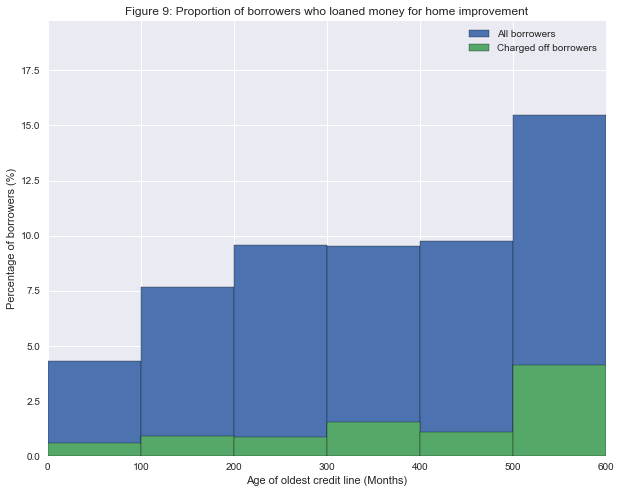

In [13]:
# Creating Figure 9
plt.figure(figsize = (10,8))
plt.bar(np.arange(0, 800, bin_width), width = bin_width, 
        height = 100*CAG_all_borrowers.loc['purpose_home_improvement',:], align = 'edge', 
        edgecolor = 'black', label = 'All borrowers')
plt.bar(np.arange(0, 800, bin_width), width = bin_width, 
        height = Contributions.loc['purpose_home_improvement',:], align = 'edge', 
        edgecolor = 'black', label = 'Charged off borrowers')
plt.title('Figure 9: Proportion of borrowers who loaned money for home improvement')
plt.xlim([0,600])
plt.xlabel("Age of oldest credit line (Months)")
plt.ylabel("Percentage of borrowers (%)")
plt.ylim([0,19.75])

plt.legend()


Figure 9 excludes borrowers above the 600 age of oldest credit account categories because they are few in number. From the figure, it appears that the reason why a greater proportion of borrowers are charged off for home improvement in the 500-600 months category is because a significantly larger proportion of borrowers in that category loan money for home improvement. To check this claim, a two tailed hypothesis test is used.

**Hypothesis test 4**

The null and alternative hypothesis are stated below:
* H<sub>0</sub>: $\mu$<sub>500-600</sub> = $\mu$<sub>0-500</sub>
* H<sub>1</sub>: $\mu$<sub>500-600</sub> $\neq$ $\mu$<sub>0-500</sub>

In words, 
* The null hypothesis states that there is not a significant difference in the proportion of borrowers that loaned money for home improvement in the 500 to 600 age of oldest credit account category and the 0-500 age of oldest credit account categories. 
* The alternative hypothesis states there is a significant difference in the proportion of borrowers that loaned money for home improvement in the 500 to 600 age of oldest credit account category and the 0-500 age of oldest credit account categories. 

The test is carried out at the 5% significance level.

In [14]:
# creating dataframes of respective categories
age_below_500 = loan_data[(loan_data.age_cr_line< 500)]
age_500_600 = loan_data[(loan_data.age_cr_line>=500)& (loan_data.age_cr_line <600)]

# calculating the test statistic and p-value
st.ttest_ind(age_below_500.purpose_home_improvement, age_500_600.purpose_home_improvement)

Ttest_indResult(statistic=-2.9842625993976131, pvalue=0.0028443555802270745)

Given the p-value of 0.0028 is less than 5%, we reject the null hypothesis. At the 5% significant level, results suggest that there is a significant difference between the proportion of borrowers that loaned money for home improvement in the 500-600 age of oldest credit account category and the 0-500 age of oldest credit account categories. This raises the question, which borrowers are most likely to loan money for home improvement?


Below we plot a graph showing the proportion of borrowers that loan money for home improvement by home ownership

,0
home_ownership_NONE,0
home_ownership_OTHER,5
home_ownership_OWN,335
home_ownership_RENT,263
home_ownership_MORTGAGE,2377


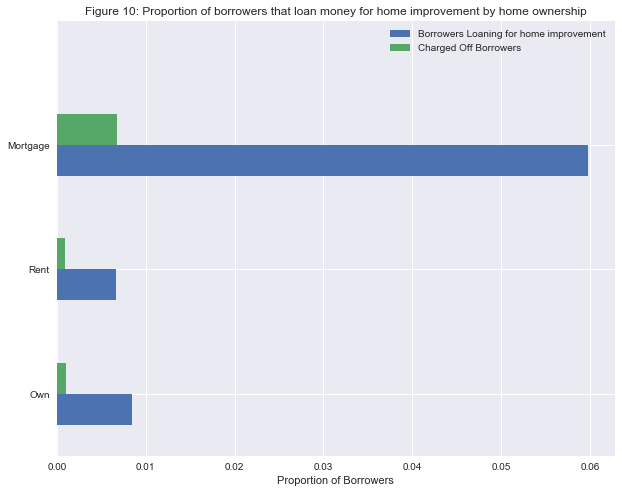

In [15]:
# creating a list of home ownership of borrowers
home_ownerships = list()

for column_name in loan_data.columns.tolist():
    if 'home_ownership' in column_name:
        home_ownerships.append(column_name)

# creating a dataframe of cahrged off borrowers improving their homes
home_improvers = loan_data[loan_data.purpose_home_improvement ==1]
home_improvers_C = home_improvers[home_improvers['loan_status'] == 0]

# counting the number of home improvers
home_improvers_sum = home_improvers[home_ownerships].sum()
home_improvers_sum.loc['home_ownership_MORTGAGE'] = len(home_improvers) - home_improvers_sum.sum()

# creating a dataframe of total home owners in each catagory
home_owners_T_sum = loan_data[home_ownerships].sum()
home_owners_T_sum.loc['home_ownership_MORTGAGE'] = len(loan_data) - home_owners_T_sum.sum()

# calculating proportions for comparison
proportions = home_improvers_sum/home_owners_T_sum.sum()

home_improvers_C_sum = home_improvers_C[home_ownerships].sum()
home_improvers_C_sum.loc['home_ownership_MORTGAGE'] = len(home_improvers_C) - home_improvers_C_sum.sum()
proportions_charged_off = home_improvers_C_sum/home_owners_T_sum.sum() 

# creating figures
temp = pd.concat([proportions, proportions_charged_off], axis=1)
ax = temp.iloc[2:].plot(kind = 'barh', figsize=(10,8))
ax.legend(['Borrowers Loaning for home improvement', 'Charged Off Borrowers'], loc = 0)
plt.title('Figure 10: Proportion of borrowers that loan money for home improvement by home ownership')
plt.xlabel('Proportion of Borrowers')
plt.yticks([0,1,2], ['Own', 'Rent', 'Mortgage'])
plt.ylim([-0.5, 3])

pd.DataFrame(home_improvers_sum)

The table above Figure 10 shows the count of borrowers in each home ownership category. Categories with 5 or less borrowers are not included in Figure 10 as the sample size is small. We see in Figure 10 that borrowers that have their homes on mortgages are the most likely to try to improve it. In addition, we understand that the major contributor to default risk amongst borrowers that loan money for home improvement are borrowers whose homes are on mortgage. 

While there is currently no evidence for this, it seems worth checking whether there is an association between borrowers that have their homes on mortgages and borrowers that default. For this, a $\chi$<sup>2</sup>  test will be used.

**Hypothesis test 5**

The null and alternative hypothesis are stated below:
* H<sub>0</sub>: There is no association between loan status and borrowers that have their homes mortgaged.
* H<sub>1</sub>: There is an association between loan status and borrowers that have their homes mortgaged.

The hypothesis is carried out at the 5% significant level. 

In [16]:
# defining significance level
sig_level = 0.05

# creating a mortgage column using mortgeage maker
def mortgage_maker(row):
    
    mortgage = int()
    
    if (row.home_ownership_NONE == 0) & (row.home_ownership_OTHER == 0) & (row.home_ownership_OWN == 0) & (row.home_ownership_RENT == 0):
        
        mortgage = 1
        
    return mortgage

mortgage_df = loan_data.copy()
mortgage_df['home_ownership_MORTGAGE'] = mortgage_df.apply(mortgage_maker, axis = 1)

# creating contingency table 
cont_table = pd.crosstab(index= mortgage_df.loan_status, columns=mortgage_df['home_ownership_MORTGAGE'])

# calculating test statistic and p-value
chi2, pval, _, _ = st.chi2_contingency(cont_table)

# printing results
if pval > sig_level:
    print("Chi-squared test statistic (" + str(chi2) + ") > p-value (" + str(pval) + ')') 
elif pval < sig_level:
    print("p-value(" + str(pval) + ") < significance level (" + str(sig_level) + ')')

# displaying contingency table
pd.crosstab(index= mortgage_df.loan_status, columns=mortgage_df['home_ownership_MORTGAGE'], 
            normalize = 'columns')

p-value(9.18139085457e-07) < significance level (0.05)


home_ownership_MORTGAGE,0,1
loan_status,,
0,0.150018,0.132659
1,0.849982,0.867341


The p-value is less than the significance level so we reject the null hypothesis. There is evidence at the 5% siginificance level to suggest that there is an association between loan status and borrowers that have their home mortgaged. The contingency matrix shown above is normalized by columns: it shows that 15% of borrowers without a mortgage are chcarged off while 13.3% of borrowers with a mortgage are charged off. Given the result of the chi-square test, we can conclude that borrowers who have their homes mortgaged are less likely to be charged off than those with mortgages.  

#### Borrowers with longer employment lengths
It is believed that borrowers with longer lengths of employment are less likely to default on loans. This is because long employment lengths are an indicator of a stable income. Similar to before, we show the two plots below to begin investigating this:
* Figure 11 shows the distribution of employment length
* Figure 12 shows proportion of borrowers that defaulted in each employment length category.

Text(0,0.5,'Percentage of charged off borrowers (%)')

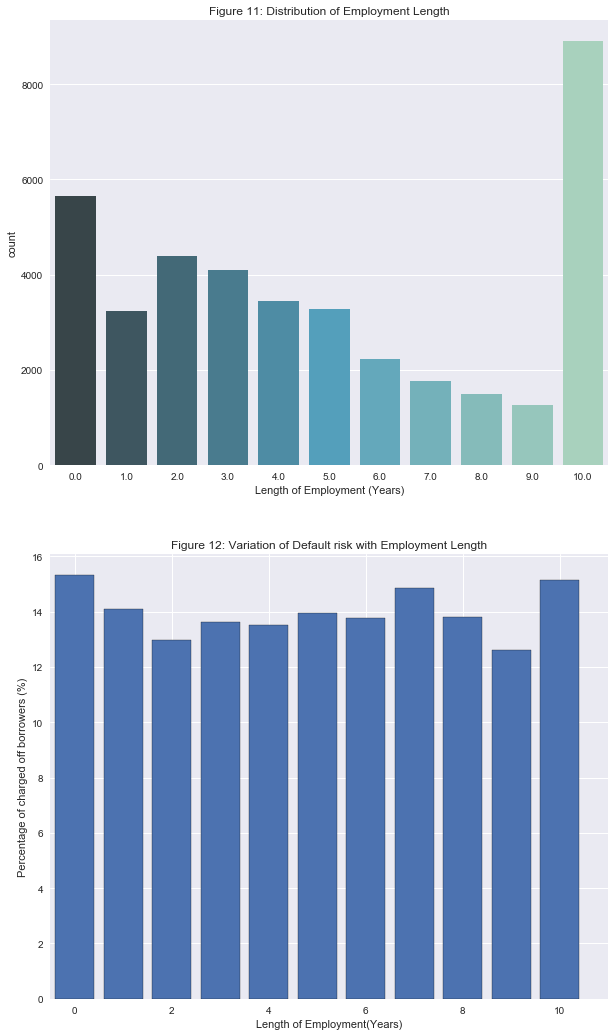

In [17]:
# creating a dataframe of charged off loans
charged_off = loan_data[loan_data['loan_status'] == 0]

# count of the number of people of each employment length that were charged off
count_charged_off  = charged_off['emp_length'].value_counts().sort_index()

# counting the number of people of each employment 
count_total = loan_data.emp_length.value_counts().sort_index()

# calculating the proportiong of people of each employment length 
proportion = 100*count_charged_off/count_total


# creating graphs 
plt.figure(figsize = (10,18))

# plotting the distribution of employment length
plt.subplot(2,1,1)
plt.title('Figure 11: Distribution of Employment Length')
sns.countplot(x = 'emp_length', data=loan_data, palette='GnBu_d')
plt.xlabel('Length of Employment (Years)')

# plotting a chart showing the proportiong of people charged off in each category
plt.subplot(2,1,2)
bin_width = 0.8
plt.bar(np.arange(0, 11, 1), height = proportion, width = bin_width, align = 'center',
        edgecolor = 'black')
plt.xlim([-0.5,11])
plt.title('Figure 12: Variation of Default risk with Employment Length')
plt.xlabel("Length of Employment(Years)")
plt.ylabel("Percentage of charged off borrowers (%)")



The employment length distribution shown in Figure 11 is trimodal. The mode on the right end of the distribution consists of people with 10 or more years of employment. A majority of borrowers in the Lending Club marketplace fall into this category. 

In Figure 12, we see that there is no trend between the employment length and the percentage of borrowers that defaulted. To check this we use a hypothesis test. 

**Hypothesis test 6**

The null and alternative hypothesis are stated below:
* H<sub>0</sub>: $\rho$ = 0 
* H<sub>1</sub>: $\rho$ $\neq$ 0

In words, 
* The null hypothesis states that there is no significant relationship between the employment legnth and proportion of charged off borrowers. 
* The alternative hypothesis states that there is a significant relationsip between the employment length and proportion of charged off borrowers.

The test is carried out at the 5% significance level.

Spearman's Correlation Coefficient: -0.0818181818182
p-value: 0.8109903943


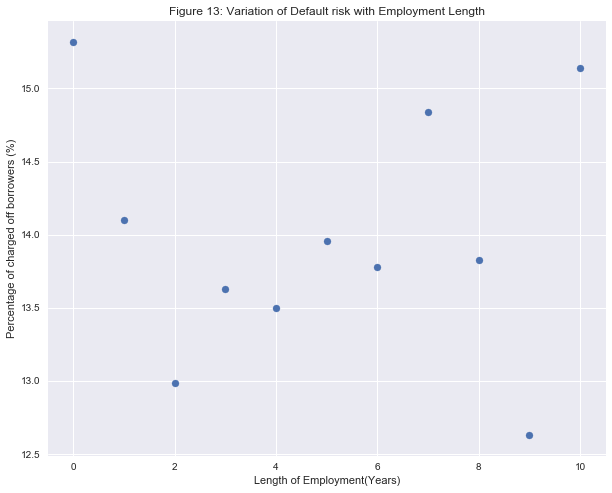

In [18]:
# creating scatter plot 
plt.figure(figsize = (10,8))
plt.scatter(x= np.arange(0, 11, 1), y = proportion)
plt.title('Figure 13: Variation of Default risk with Employment Length')
plt.xlabel("Length of Employment(Years)")
plt.ylabel("Percentage of charged off borrowers (%)")

# calculating the correlation coeeficient and p-value
x= np.arange(0, 11, 1)
corr_coeff, p_val = st.spearmanr(x, proportion)

print('Spearman\'s Correlation Coefficient: ' + str(corr_coeff))
print('p-value: ' + str(p_val))

It should be noted that the y-axis of Figure 13 above has a lower limit of 12.5%. 

Given the p-value (0.81) is greater than the significance level we fail to reject the null hypothesis. Results suggest that there is no relationship between the employment length and proportion of charged off borrowers at the 5% significance level. 

While this is not what was expected, it is in agreement with the findings of the Fair Isaac Corporation (FICO): FICO score models do not make use of employment history information as it was found not to be predictive of future credit performance. Consequently, we can conclude that employment history is likely not a useful metric for evaluating default risk.

#### Borrowers with larger annual incomes
Similar to the length of employment, FICO score models do not make use of annual income in computing a borrower's credit score as they have found it does not predict future credit performance. It is worth investigating whether this findings hold for the Lending Club dataset.

Text(0,0.5,'Percentage of charged off borrowers (%)')

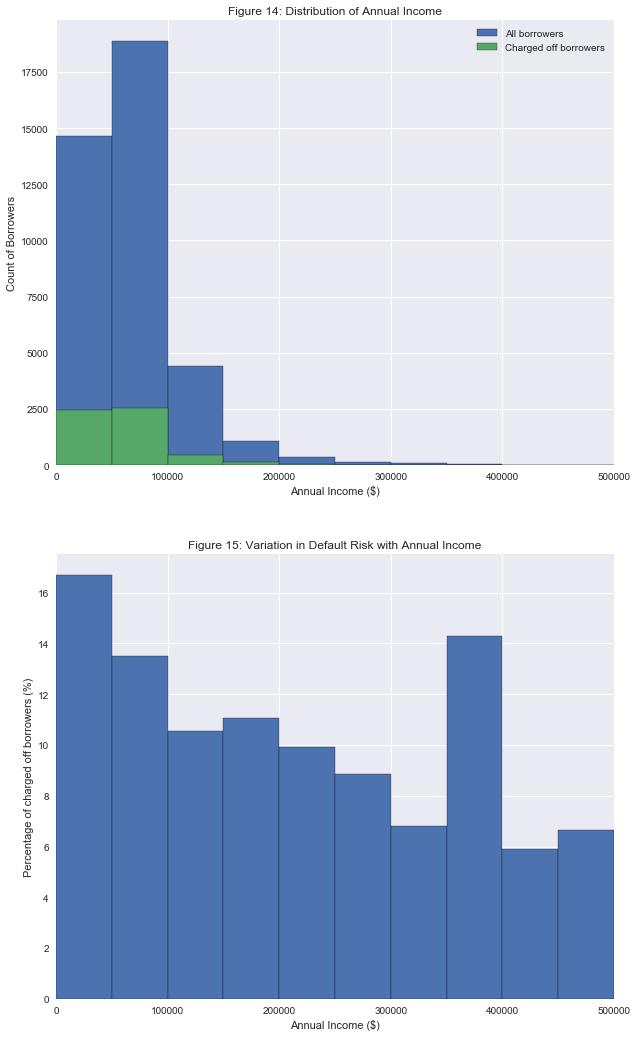

In [19]:
# creating a dataframe of charged off loans
charged_off = loan_data[loan_data['loan_status'] == 0]

# creating empty list for bin edges and specifying bin width
bin_edges = list()
bin_width = 50000

# choosing the maximum x axis display
max_el = 500000

# filling in list of bin widths
for num in range(int(round((max_el/bin_width)+1))):
    bin_edges.append((num)*bin_width)

# creating the figure
plt.figure(figsize = (10,18))

# plotting the distribution of annual income
plt.subplot(2,1,1)
plt.title('Figure 14: Distribution of Annual Income')
plt.xlabel("Annual Income ($)")
plt.ylabel('Count of Borrowers')
plt.xlim([0,max_el])

# counting the number of borrowers in each annual income category
counts_tot, bins_tot, bars_tot= plt.hist(loan_data.annual_inc, bins = bin_edges, 
                                         label = 'All borrowers', edgecolor = 'k')

# count of the number of borrowers in each annual income category that were charged off
counts, bins, bars = plt.hist(charged_off['annual_inc'], bins = bin_edges, 
                              label = "Charged off borrowers", edgecolor = 'k')

# displaying a legend on the plot
plt.legend()

# calculating the proportions of borrowers charged off in each category
proportions = 100*counts/counts_tot

# Make a bar chart showing the proportions 
plt.subplot(2, 1, 2)
plt.bar(np.arange(0, max_el, bin_width), height = proportions, width = bin_width, align = 'edge',
        edgecolor = 'black')
plt.title('Figure 15: Variation in Default Risk with Annual Income')
plt.xlim([0,max_el])
plt.xlabel("Annual Income ($)")
plt.ylabel("Percentage of charged off borrowers (%)")

It should be noted that in figures 14 and 15 only incomes less than \$500,000 are shown and analyzed. Incomes above $500,000 were excluded because they are few and make the graphs difficult to read.

We see from Figure 14 that the income distribution is right skewed with most borrowers earning between \$50,000 to \$100,000. 

The graphs in Figure 15 shows that the risk of borrowers defaulting generally decreases as annual incomes increase for borrowers earning between \$0 to \$350,000. Oddly borrowers earning between \$350,000 to \$400,000 deviate from this trend. It is worth noting that the significant deviation in the general decline occurs for annual incomes in which the count of borrowers is relatively small :

|   Annual Income ($)   | Count of people in category   | Count of people charged off     |
|-----------------------|-------------------------------|---------------------------------|
|  350,000 - 400,000    |               35              |             5                   |
|  400,000 - 450,000    |               17              |             1                   |
|  450,000 - 500,000    |                8              |             1                   |

It is possible that the deviation is not statistically significant. Let's investigate this using a hypothesis test

**Hypothesis test 7** 

The null and alternative hypothesis are stated below:
* H<sub>0</sub>: p = p<sub>0</sub>
* H<sub>1</sub>: p $\neq$ p<sub>0</sub>

where,
 - p is the proportion of charged off borrowers in the \$300,000 to \$350,000 income category and the \$400,000 to \$450,000 income category. 
 - p<sub>0</sub> is the proportion of charged off borrowers in the \$350 to \$400,000 income category
 
The hypothesis test is carried out at the 5% siginificance level

In [20]:
# defining significance level
sig_level = 0.05
        
# calculating the p-value
p_value_t = st.ttest_ind(loan_data[((loan_data.annual_inc >= 300000) & 
                                   (loan_data.annual_inc < 350000)) | 
                                   ((loan_data.annual_inc >= 400000) & 
                                   (loan_data.annual_inc < 450000))].loan_status,
                         loan_data[(loan_data.annual_inc >= 350000) & 
                                   (loan_data.annual_inc < 400000)].loan_status)[1]
                            
# adding results to dataframe
if p_value_t < sig_level:
    print('p-value (' + str(p_value_t) + ') < 0.05')
else:
    print('p-value (' + str(p_value_t) + ') > 0.05')


p-value (0.165512116308) > 0.05


We see from the above result that we fail to reject the null hypothesis. Results suggest there is not a significant difference between the proportion of charged off borrowers in the \$350,000 - $400,000 income category relative to the proportion of charged off borrowers in its two neighbouring categories. 

Based on the result of the hypothesis test, it is reasonable for investors to use a borrower's annual income as a metric to judge default risk. However, it may be beneficial for conservative investors to be cautious about loaning money to annual income groups with few borrowers. Overall, it will likely be advantageous to combine annual income with another metric when trying to minimize risk of investing in borrowers that default. 

### Borrowers requesting smaller loans
Larger loan amounts typically means larger installments. Having consistently large financial obligations can be difficult to manage particularly if costly emergencies arise. For this reason, it is expected that greater loan amounts will have more defaults. 

Text(0.5,1,'Figure 17: Variation of Loan amounts with Default risk')

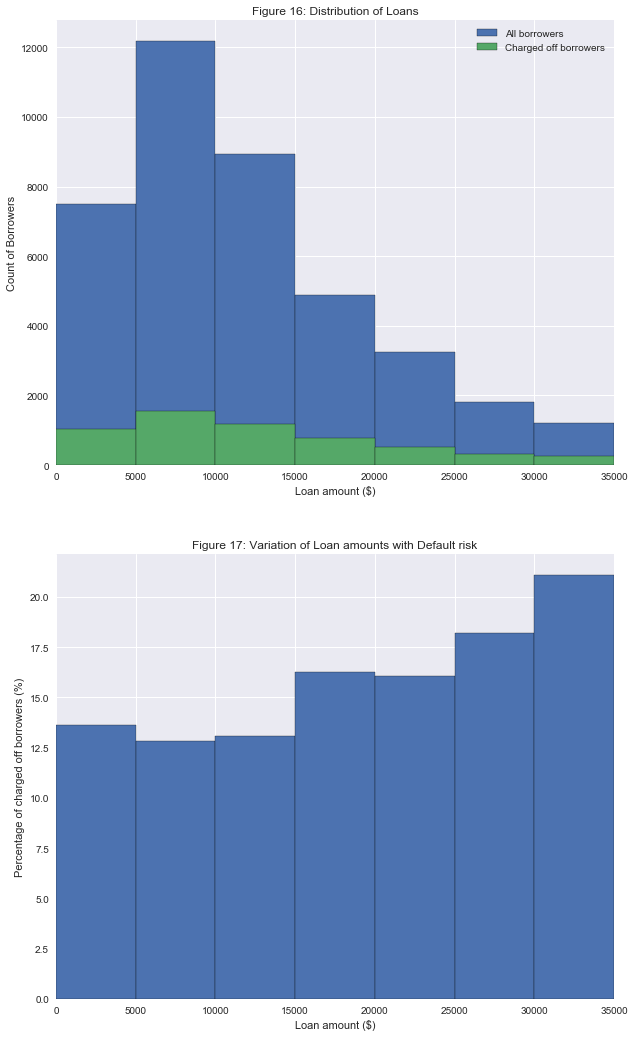

In [21]:
# creating a dataframe of charged off loans
charged_off = loan_data[loan_data['loan_status'] == 0]

# creating empty list for bin edges and specifying bin width
bin_edges = list()
bin_width = 5000

# creating the maximum x axis display
max_el = loan_data.loan_amnt.max()

# filling 
for num in range(int(round((max_el/bin_width)+1))):
    bin_edges.append((num)*bin_width)

# creating figure
plt.figure(figsize = (10,18))

# plotting distribution of loan amounts
plt.subplot(2,1,1)
plt.xlabel("Loan amount ($)")
plt.ylabel('Count of Borrowers')
plt.xlim([0,max_el])
plt.title("Figure 16: Distribution of Loans")

# counting the number of people of each age in the dataset
counts_tot, bins_tot, bars_tot= plt.hist(loan_data.loan_amnt, bins = bin_edges, 
                                         label = 'All borrowers', edgecolor = 'k')

# count of the number of borrowers that were charged off
counts, bins, bars = plt.hist(charged_off['loan_amnt'], bins = bin_edges, 
                              label = "Charged off borrowers", edgecolor = 'k')

# adding a legend to the plot
plt.legend()

# calculating the proportions of loan amounts charged off
proportions = 100*counts/counts_tot

# Make a bar chart showing the proportions of loan amounts in each category that was charged off
plt.subplot(2, 1, 2)
plt.bar(np.arange(0, max_el, bin_width), height = proportions, width = bin_width, align = 'edge',
        edgecolor = 'black')
plt.xlim([0,max_el])
plt.xlabel("Loan amount ($)")
plt.ylabel("Percentage of charged off borrowers (%)")
plt.title('Figure 17: Variation of Loan amounts with Default risk')

In Figure 16, we can see that the loan distribution is right skewed and that most of the borrowers offered on Lending Club market place request a loan amount between \$5,000 to $10,000.   

From Figure 17 we note that as the loan amount increases, there is a general increase in the percentage of defaulters. As expected, this suggests that it is less risky to invest in borrowers requesting smaller loan amounts.

emp_title_cat_Educational Institutions    0.107871
emp_title_cat_Major Retailers             0.172872
emp_title_cat_No response                 0.196914
emp_title_cat_Tech companies (FAANG)      0.083333
emp_title_cat_US Military                 0.140000
emp_title_cat_Uncategorized employer      0.141192
emp_title_cat_self_employed               0.186170
emp_title_cat_unemployed                  0.191489
dtype: float64

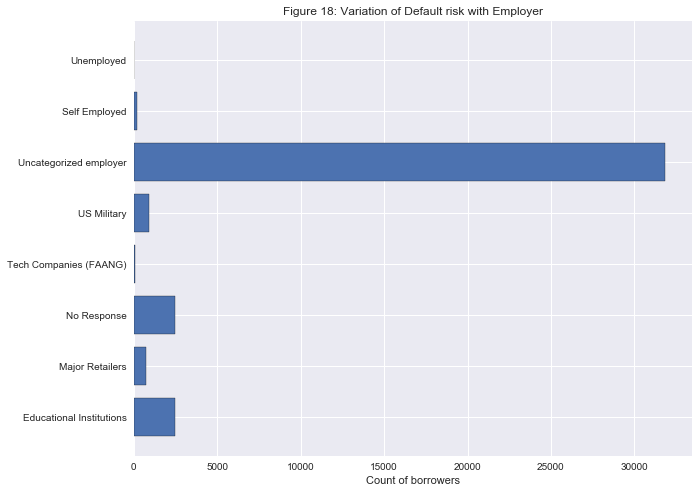

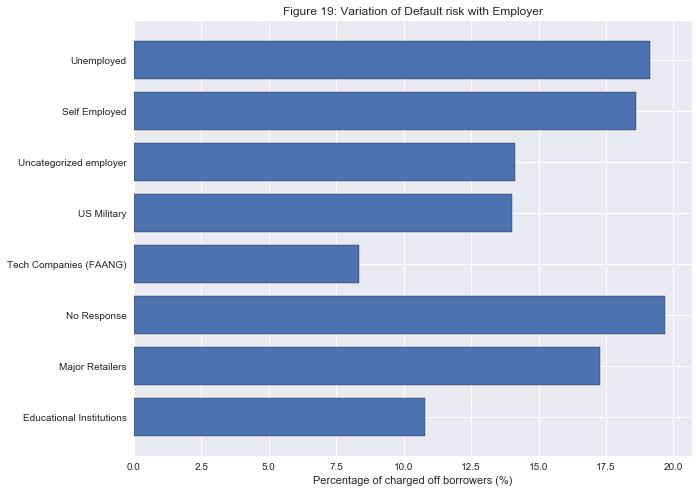

In [22]:
# creating list of employer 
emp_titles = list()

for emp_title in loan_data.columns.tolist():
    if 'emp_title_cat' in emp_title:
        emp_titles.append(emp_title)

# counting the number of borrowers in each employer category 
emp_title_count = loan_data[emp_titles].sum() 

# plotting a chart showing the count of people in each employmer category
fig, ax = plt.subplots(figsize=(10,8))
bin_width = 0.8
plt.barh(np.arange(0, 8, 1), width = emp_title_count, height = 0.75, align = 'center',
        edgecolor = 'black')

plt.title('Figure 18: Variation of Default risk with Employer')
plt.xlabel("Count of borrowers")

# formatting employer displayed
formatted_emp_title = ['Educational Institutions','Major Retailers', 'No Response',
                       'Tech Companies (FAANG)', 'US Military','Uncategorized employer',
                       'Self Employed', 'Unemployed']
plt.yticks(np.arange(0, 8, 1), formatted_emp_title)

# calculating proportions
emp_title_df = loan_data[emp_titles]
proportions = emp_title_df[loan_data.loan_status == 0].sum()/emp_title_df.sum()

# plotting aproportiong of people charged off in each category
fig, ax = plt.subplots(figsize=(10,8))
bin_width = 0.8
plt.barh(np.arange(0, 8, 1), width = 100*proportions, height = 0.75, align = 'center',
        edgecolor = 'black')

plt.title('Figure 19: Variation of Default risk with Employer')
plt.xlabel("Percentage of charged off borrowers (%)")

# formatting employer titles displayed
formatted_emp_title = ['Educational Institutions','Major Retailers', 'No Response',
                       'Tech Companies (FAANG)', 'US Military','Uncategorized employer',
                       'Self Employed', 'Unemployed']
plt.yticks(np.arange(0, 8, 1), formatted_emp_title)

proportions

In Figure 18 we see that only a small fraction of the employment title column was categorized. Figure 19 suggests that there may be significant differences in the proportion of charged off borrowers when categorized by employer titles. Let's further investigate this using a t-test.

**Hypothesis test 8**

The null and alternative hypothesis are stated below:
* H<sub>0</sub>: p - p<sub>0</sub> = 0 
* H<sub>1</sub>: p - p<sub>0</sub> $\neq$ 0

where
- p is the proportion of charged off borrowers in all other employer categories combined.
- p<sub>0</sub> is the observed proportion of charged off borrowers for the employer title under consideration.

The hypothesis test will be carried out at the 5% significant level.

In [23]:
# calculating p
p = len(charged_off)/len(loan_data)

# calculating number of borrowers in population
n = len(loan_data)

# creating a dataframe to store test results
T_test_results = pd.DataFrame()

# creating a for loop to calculate p-value and compare it to significance level
for emp_title in emp_titles:

    # defining significance level
    sig_level = 0.05
        
    # calculating the p-value
    p_value_t = st.ttest_ind(loan_data[loan_data[emp_title] !=1].loan_status,
                             loan_data[loan_data[emp_title] ==1].loan_status)[1]
        
    # adding results to dataframe
    if p_value_t < sig_level:
        T_test_results.loc[emp_title, 'Result'] = 'Significant'
        T_test_results.loc[emp_title, 'Explanation'] = 'p-value (' + str(p_value_t) + ') < 0.05'
    else:
        T_test_results.loc[emp_title, 'Result'] = 'Not Significant'
        T_test_results.loc[emp_title, 'Explanation'] = 'p-value (' + str(p_value_t) + ') > 0.05'

T_test_results['Employer Categories'] = formatted_emp_title 
T_test_results[['Employer Categories', 'Result', 'Explanation']]

,Employer Categories,Result,Explanation
emp_title_cat_Educational Institutions,Educational Institutions,Significant,p-value (3.52914654557e-07) < 0.05
emp_title_cat_Major Retailers,Major Retailers,Significant,p-value (0.0153613048026) < 0.05
emp_title_cat_No response,No Response,Significant,p-value (1.09767347308e-15) < 0.05
emp_title_cat_Tech companies (FAANG),Tech Companies (FAANG),Not Significant,p-value (0.0790585949643) > 0.05
emp_title_cat_US Military,US Military,Not Significant,p-value (0.842391921244) > 0.05
emp_title_cat_Uncategorized employer,Uncategorized employer,Not Significant,p-value (0.209022597045) > 0.05
emp_title_cat_self_employed,Self Employed,Not Significant,p-value (0.0842875897068) > 0.05
emp_title_cat_unemployed,Unemployed,Not Significant,p-value (0.334012197658) > 0.05


The results shown in the above table suggest that 3 of the 8 employment title categories have significantly different proportions of charged off borrowers relative to the other categories of charged off borrowers. We note that it is reasonable for the uncategorized employer category not to be significantly different from the population results as it is currently composed of over 80% of the loan dataset. Given the results, it will likely be beneficial to fully categorize the employment title column as it could provide useful insights into the default risk of a loan.

## Do Sub-grades matter? 
Lending Club categorize borrowers based on grades and sub grades. The grades are lettered A through G, with the letter A representing the least risky borrowers to invest in, and the letter G representing the most risky borrowers to invest in. The sub-grades are numbered 1 through 5 with the number 1 for the borrowers within a grade that are less likely to default and the number 5 for those more likely to default. 

In this section, we hope to gain some insight into whether investing based on sub-grades can help reduce an investors risk. To this end, we plot graphs to show the distribution and default risks associated with grades and sub-grades. 

([<matplotlib.axis.XTick at 0x11992fac8>,
 <a list of 7 Text xticklabel objects>)

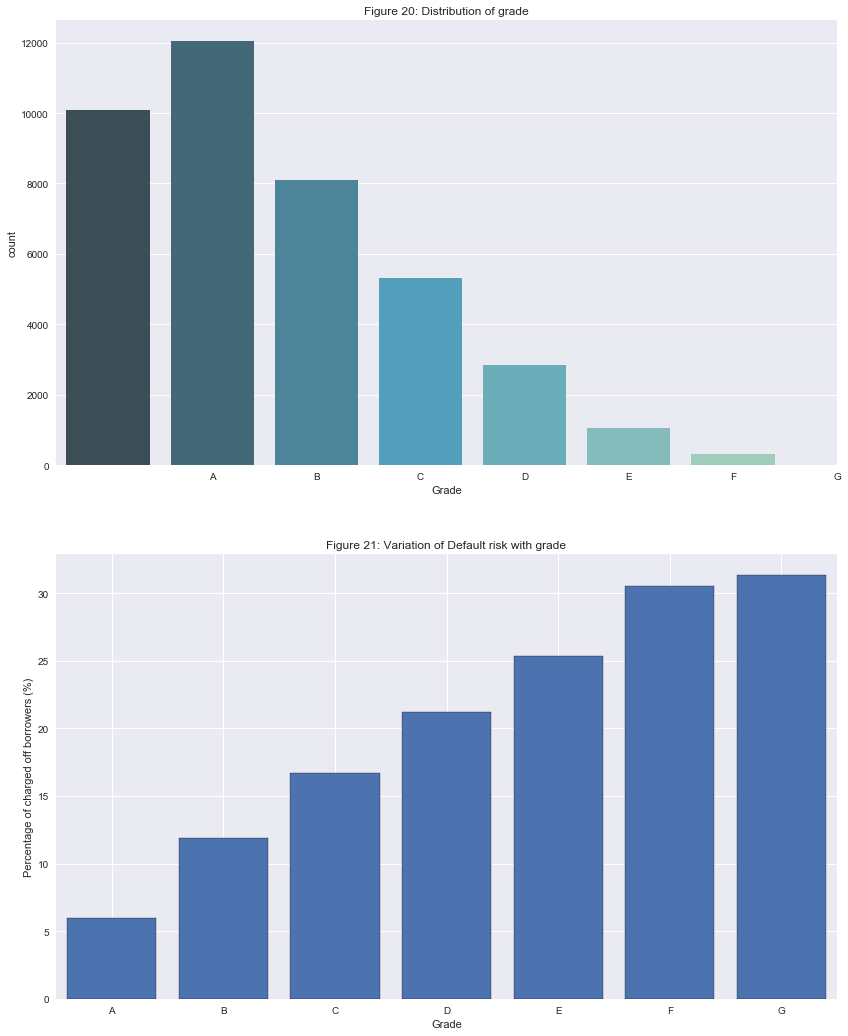

In [24]:
# creating a dataframe of charged off loans
charged_off = loan_data[loan_data['loan_status'] == 0]

# count of the number of people of each employment length that were charged off
count_charged_off  = charged_off['grade'].value_counts().sort_index()

# counting the number of people of each employment 
count_total = loan_data.grade.value_counts().sort_index()

# calculating the proportiong of people of each employment length 
proportion = 100*count_charged_off/count_total

# creating graphs 
plt.figure(figsize = (14,18))

# plotting the distribution of employment length
plt.subplot(2,1,1)
plt.title('Figure 20: Distribution of grade')
sns.countplot(x = 'grade', data=loan_data, palette='GnBu_d')
plt.xlabel('Grade')
plt.xticks(np.arange(1,8,1), ["A", "B", "C", "D", "E", "F", "G"])

# plotting a chart showing the proportiong of people charged off in each category
plt.subplot(2,1,2)
bin_width = 0.8
plt.bar(np.arange(1, 8, 1), height = proportion, width = bin_width, align = 'center',
        edgecolor = 'black')
plt.title('Figure 21: Variation of Default risk with grade')
plt.xlabel("Grade")
plt.ylabel("Percentage of charged off borrowers (%)")
plt.xlim([0.5,7.5])
plt.xticks(np.arange(1,8,1), ["A", "B", "C", "D", "E", "F", "G"])



We see in Figure 20 that the distribution of grades is right skewed indicating that a majority of borrowers in the Lending Club market place have grade A or B loans. Figure 21 shows that the risk of a borrower defaulting increases as grades increase; this is expected. 

([<matplotlib.axis.XTick at 0x1172eadd8>,
 <a list of 7 Text xticklabel objects>)

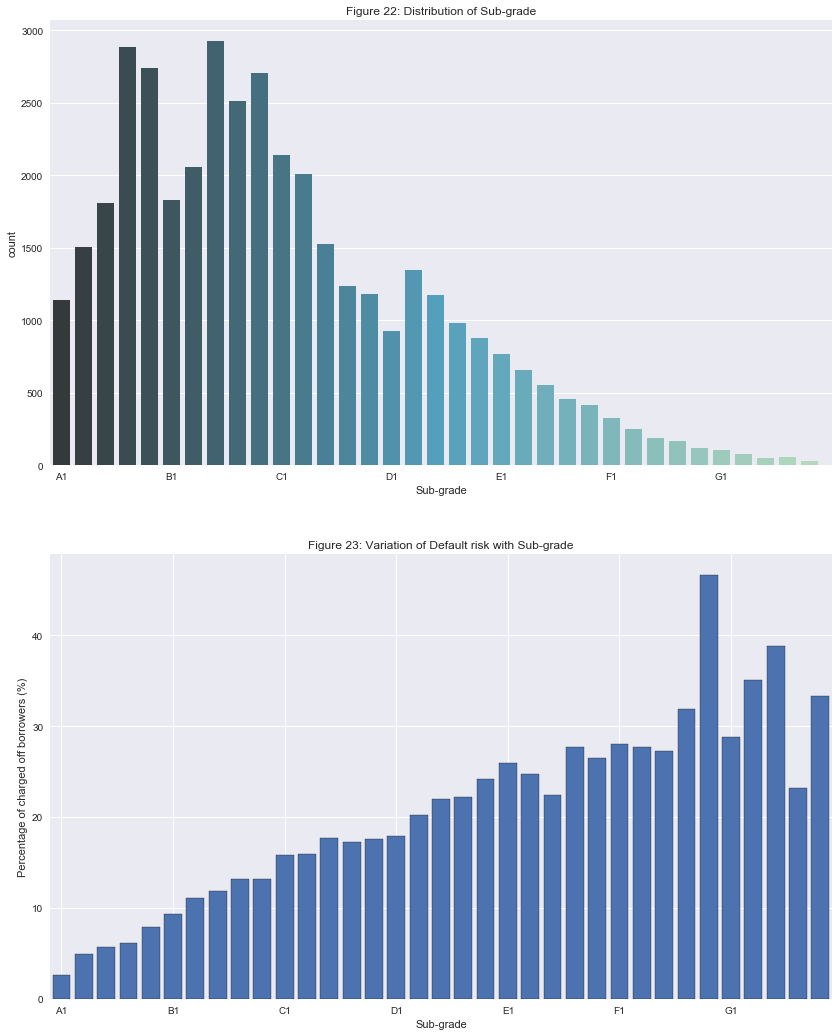

In [25]:
# creating a dataframe of charged off loans
charged_off = loan_data[loan_data['loan_status'] == 0]

# count of the number of people of each employment length that were charged off
count_charged_off  = charged_off['sub_grade'].value_counts().sort_index()

# counting the number of people of each employment 
count_total = loan_data.sub_grade.value_counts().sort_index()

# calculating the proportiong of people of each employment length 
proportion = 100*count_charged_off/count_total


# creating graphs 
plt.figure(figsize = (14,18))

# plotting the distribution of employment length
plt.subplot(2,1,1)
plt.title('Figure 22: Distribution of Sub-grade')
sns.countplot(x = 'sub_grade', data=loan_data, palette='GnBu_d')
plt.xlabel('Sub-grade')
plt.xticks(np.arange(0,36,5), ["A1", "B1", "C1", "D1", "E1", "F1", "G1"])

# plotting a chart showing the proportiong of people charged off in each category
plt.subplot(2,1,2)
bin_width = 0.8
plt.bar(np.arange(1, 36, 1), height = proportion, width = bin_width, align = 'center',
        edgecolor = 'black')
plt.title('Figure 23: Variation of Default risk with Sub-grade')
plt.xlabel("Sub-grade")
plt.ylabel("Percentage of charged off borrowers (%)")
plt.xlim([0.5,35.5])
plt.xticks(np.arange(1,36,5), ["A1", "B1", "C1", "D1", "E1", "F1", "G1"])

Figure 22 shows a more datailed distribution of of the grades, the sub-grade distribution. We note that the sub-grade distribution is trimodal. We also note from Figure 23 that there is a general increase in default risk as sub-grade increases, for sub-grades labelled less than the number 22 (D2). For sub grades ranked more risky than D2, there is no clear pattern. This indicates that there may be issues with the sub-grade classification for riskier borrowers. 

It is worth investigating whether there is an association between sub-grade and charged off borrowers. For this, we use a hypothesis test.

**Hypothesis test 9**

The null and alternative hypothesis are stated below:
* H<sub>0</sub>: $\rho$ = 0 
* H<sub>1</sub>: $\rho$ $\neq$ 0

In words, 
* The null hypothesis states that there is no significant relationship between the sub-grade and proportion of charged off borrowers. 
* The alternative hypothesis states that there is a significant relationsip between the sub-grade and proportion of charged off borrowers.

The hypothesis is carried out at the 5% significant level. 

Spearman's Correlation Coefficient: 0.963025210084
p-value: 2.28302678791e-20


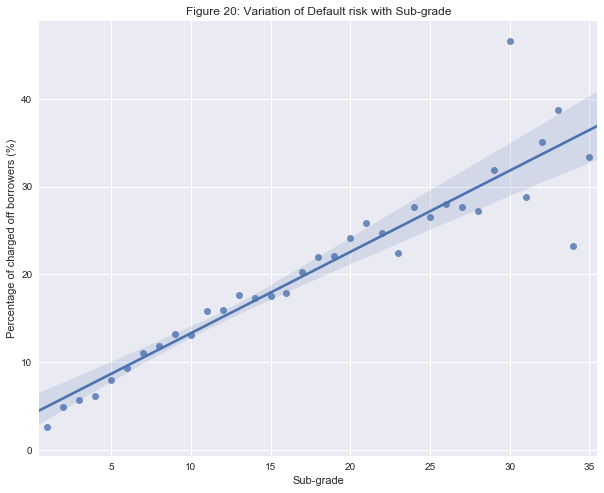

In [26]:
# Making histogram
fig, ax1 = plt.subplots(figsize = (10,8))

sns.regplot(x=np.arange(1, 36, 1), y = proportion, ax =ax1)


plt.title('Figure 20: Variation of Default risk with Sub-grade')
plt.xlabel("Sub-grade")
plt.ylabel("Percentage of charged off borrowers (%)")
plt.xlim([0.5,35.5])

# calculating the correlation coeeficient and p-value
x = np.arange(1, 36, 1)
corr_coeff, p_val = st.spearmanr(x, proportion)

print('Spearman\'s Correlation Coefficient: ' + str(corr_coeff))
print('p-value: ' + str(p_val))

Given the p-value is less than the 5% significance level, we reject the null hypothesis. Results suggest that there is a significant relationship between sub-grade and percentage of charged off borrowers. Thus, it can be concluded that sub-grades impacts default risk. 

In summary, we see that there is a lot to consider if an investor is attempting to minimize risks. For one, there are a lot of metrics involved. Furthermore, some metrics don't always behave the way we expect (employment history) or when they do, there may be random deviations from expected trends (age of oldest credit account and annual income). As an investor keeping all these considerations in mind can be difficult. For these reasons creating a machine learning model can be beneficial. 